# Analysis on Twitter Tweets

In [95]:
# Import libraries

# Usual libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import string
import random

# NLTK
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Assigning variables
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
stop_words = stopwords.words('english')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as gbm
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# Doc/Word Vectors
from gensim.models.fasttext import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary

# LDA and LSI Models
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import LsiModel, CoherenceModel
from gensim.models import TfidfModel
from gensim.models import LdaModel, LdaMulticore
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Spacy
import spacy
from spacy.lang.en.examples import sentences
from spacy import displacy
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')
stopwords_nlp = nlp.Defaults.stop_words

# LIME and SHAP
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import shap

# Set seed
np.random.seed(123)

In [96]:
df = pd.read_csv(r'C:\Users\Scott\Box\Shyam\01_Shyam_Personal\Text Mining\Twitter\twitter_data.csv',
usecols=['Tweet ID', 'Date Created', 'Number of Likes', 'Number of Replies', 'Number of Retweets', 'Source of Tweet','Tweet'])

df.shape

(17818, 7)

## Data Cleaning

In [97]:
# Check for duplicates and drop them
print(len(df))
df.drop_duplicates(['Tweet ID'])
print(len(df))

17818
17818


In [98]:
# Loop through the column and clean the data

new_text = []

for text in df['Tweet']:
    text = re.sub(r'[!"#$%&()*+,-./:;<=>?[\]^_`{|}~]', ' ', text).lower()               # Remove punctuation and make the letters lowercase
        
    words = nltk.tokenize.word_tokenize(text)                                           # Tokenize the text
    words = [w for w in words if w.isalpha()]                                           # Ensure the data is alphabets (remove numbers)
    words = [w for w in words if len(w)>1 and w not in stopwords.words('english')]      # Remove words that are less than 2 characters and stop words as well
        
    words = [lemmatizer.lemmatize(w) for w in words]                                    # Lemmatize the words
    new_text.append(' '.join(words))

# Make a copy of the original dataframe and add the cleaned text into a new column
df['cleaned_tweet'] = new_text
df.head()

,Tweet ID,Date Created,Number of Likes,Number of Replies,Number of Retweets,Source of Tweet,Tweet,cleaned_tweet
0,1585078850253647872,2022-10-26 01:20:21+00:00,0,0,0,Twitter for Android,#MahsaAmini\n#HosainRonaghi\n#Evin\n#OpIran\n#...,mahsaamini hosainronaghi evin opiran مهسا امین...
1,1585078759543099392,2022-10-26 01:20:00+00:00,0,0,1,Twitter Web App,"#IranRevolution2022—October 25, Day 40\nTehran...",day tehran iran tabatabaei university student ...
2,1585078685815611393,2022-10-26 01:19:42+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...
3,1585078413328408576,2022-10-26 01:18:37+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...
4,1585077627765002240,2022-10-26 01:15:30+00:00,1,0,0,Twitter Web App,Abolfazl Adineh Zadeh was killed by the brutal...,abolfazl adineh zadeh killed brutal islamic re...


## Eploratory Data Analysis

In [99]:
# Count the number of likes a post has received
df['Number of Likes'].value_counts().nlargest(10)

0     10943
1      3676
2      1029
3       601
4       324
5       223
6       175
7       113
10       99
12       55
Name: Number of Likes, dtype: int64

In [100]:
df['Number of Replies'].value_counts().nlargest(10)

0     15711
1      1807
2       110
5        59
3        31
11       24
7        21
4        14
6        14
8        11
Name: Number of Replies, dtype: int64

In [101]:
df['Number of Retweets'].value_counts().nlargest(10)

0     13989
1      2407
2       425
3       183
5       175
6        90
7        83
4        75
18       33
8        31
Name: Number of Retweets, dtype: int64

<AxesSubplot:title={'center':'Source of Tweet'}>

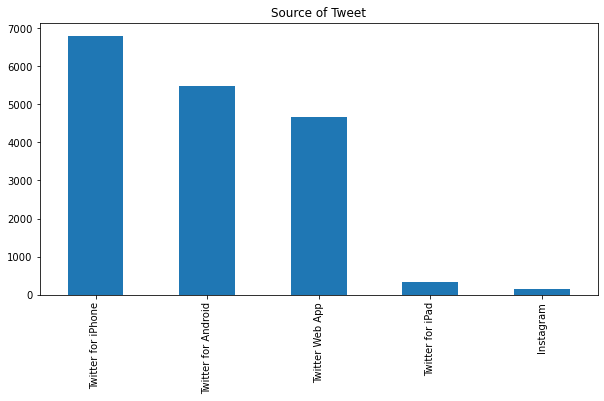

In [102]:
# Plot number of sources
df['Source of Tweet'].value_counts().nlargest(5).plot(kind='bar', figsize=(10,5), title="Source of Tweet")

## Sentiment Analysis

In [103]:
# Creating a copy of the dataframe
df_sentiment = df.copy()

In [104]:
df_sentiment['compound'] = df_sentiment['Tweet'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
df_sentiment['positive'] = df_sentiment['Tweet'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['pos'])
df_sentiment['negative'] = df_sentiment['Tweet'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['neg'])
df_sentiment.head()

,Tweet ID,Date Created,Number of Likes,Number of Replies,Number of Retweets,Source of Tweet,Tweet,cleaned_tweet,compound,positive,negative
0,1585078850253647872,2022-10-26 01:20:21+00:00,0,0,0,Twitter for Android,#MahsaAmini\n#HosainRonaghi\n#Evin\n#OpIran\n#...,mahsaamini hosainronaghi evin opiran مهسا امین...,0.0000,0.000,0.000
1,1585078759543099392,2022-10-26 01:20:00+00:00,0,0,1,Twitter Web App,"#IranRevolution2022—October 25, Day 40\nTehran...",day tehran iran tabatabaei university student ...,-0.6597,0.000,0.121
2,1585078685815611393,2022-10-26 01:19:42+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...,0.0000,0.000,0.000
3,1585078413328408576,2022-10-26 01:18:37+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...,0.0000,0.000,0.000
4,1585077627765002240,2022-10-26 01:15:30+00:00,1,0,0,Twitter Web App,Abolfazl Adineh Zadeh was killed by the brutal...,abolfazl adineh zadeh killed brutal islamic re...,-0.8402,0.095,0.318


In [105]:
print('Compound:', df_sentiment['compound'].mean())
print('Positive:', df_sentiment['positive'].mean())
print('Negative:', df_sentiment['negative'].mean())

Compound: -0.047946284655966155
Positive: 0.043946514760354986
Negative: 0.05330104388820311


Text(0.5, 1.0, 'Polarity Score Distribution')

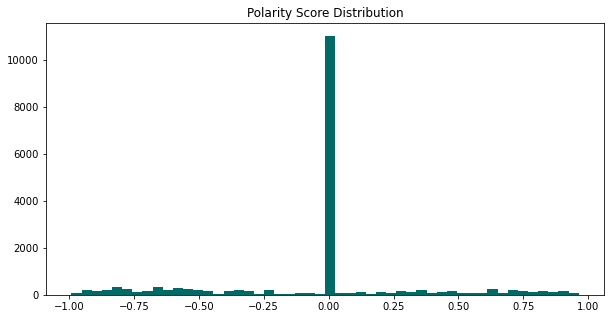

In [106]:
plt.figure(figsize=(10,5))
plt.hist(df_sentiment['compound'], bins = 50, color = '#006B66')
# plt.ylim(0,200)
plt.title('Polarity Score Distribution')

In [107]:
# Trying Spacy
# lets create a new column with the sentiment of the comment

df_sentiment['sentiment'] = df_sentiment['Tweet'].apply(lambda x: nlp(x)._.blob.polarity)

In [108]:
print('Text Blob Polartiy Score:', df_sentiment['sentiment'].mean())

Text Blob Polartiy Score: 0.01634539675398486


Text(0.5, 1.0, 'Polarity Score Distribution')

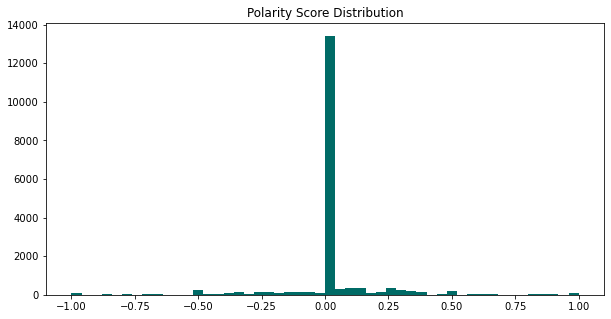

In [109]:
plt.figure(figsize=(10,5))
plt.hist(df_sentiment['sentiment'], bins = 50, color = '#006B66')
# plt.ylim(0,200)
plt.title('Polarity Score Distribution')

## Speech Scoring Prep

In [110]:
# Define a function to clean the text better using Spacy
def clean_text(text):
    # make everything lowercase
    text = text.lower()
    # only lowercase letters no numbers or special characters
    text = re.sub(r'[^a-z]', ' ', text)
    text = re.sub('https', ' ', text)
    
    # only accept nouns, pronouns and entities
    doc = nlp(text)
    text = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN', 'PRON', 'ADJ'] and len(token.text) > 3 \
        and token.text not in ('iranrevolution', 'iranprotests', 'iranrevoiution', 'freeiran', 'mahsaamini', 'mashaamini', 'iranians')]
    return text

In [111]:
# Apply function to dataframe
df['title'] = df['Tweet'].apply(clean_text)
df.head()

,Tweet ID,Date Created,Number of Likes,Number of Replies,Number of Retweets,Source of Tweet,Tweet,cleaned_tweet,title
0,1585078850253647872,2022-10-26 01:20:21+00:00,0,0,0,Twitter for Android,#MahsaAmini\n#HosainRonaghi\n#Evin\n#OpIran\n#...,mahsaamini hosainronaghi evin opiran مهسا امین...,"[mahsaamini, hosainronaghi, evin, opiran, jvlys]"
1,1585078759543099392,2022-10-26 01:20:00+00:00,0,0,1,Twitter Web App,"#IranRevolution2022—October 25, Day 40\nTehran...",day tehran iran tabatabaei university student ...,"[october, tehran, iran, capital, allameh, taba..."
2,1585078685815611393,2022-10-26 01:19:42+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...,[mashaamini]
3,1585078413328408576,2022-10-26 01:18:37+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...,"[mashaamini, semblerait, forces, oppressives, ..."
4,1585077627765002240,2022-10-26 01:15:30+00:00,1,0,0,Twitter Web App,Abolfazl Adineh Zadeh was killed by the brutal...,abolfazl adineh zadeh killed brutal islamic re...,"[abolfazl, adineh, zadeh, brutal, islamic, reg..."


In [112]:
# Creating a new column with the length of the comment
df['length'] = df['title'].apply(lambda x: len(x))
df.head()

,Tweet ID,Date Created,Number of Likes,Number of Replies,Number of Retweets,Source of Tweet,Tweet,cleaned_tweet,title,length
0,1585078850253647872,2022-10-26 01:20:21+00:00,0,0,0,Twitter for Android,#MahsaAmini\n#HosainRonaghi\n#Evin\n#OpIran\n#...,mahsaamini hosainronaghi evin opiran مهسا امین...,"[mahsaamini, hosainronaghi, evin, opiran, jvlys]",5
1,1585078759543099392,2022-10-26 01:20:00+00:00,0,0,1,Twitter Web App,"#IranRevolution2022—October 25, Day 40\nTehran...",day tehran iran tabatabaei university student ...,"[october, tehran, iran, capital, allameh, taba...",18
2,1585078685815611393,2022-10-26 01:19:42+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...,[mashaamini],1
3,1585078413328408576,2022-10-26 01:18:37+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...,"[mashaamini, semblerait, forces, oppressives, ...",7
4,1585077627765002240,2022-10-26 01:15:30+00:00,1,0,0,Twitter Web App,Abolfazl Adineh Zadeh was killed by the brutal...,abolfazl adineh zadeh killed brutal islamic re...,"[abolfazl, adineh, zadeh, brutal, islamic, reg...",12


In [113]:
# Gathering all the comments
all_comments = ' '.join(df['title'].apply(lambda x: ' '.join(x)))
len(all_comments)

1151144

In [114]:
# Check how many unique words are in the comments
total_unique = len(set(all_comments.split()))

# Average unique words per comment
unique_words_by_comment = len(set(all_comments.split())) / len(all_comments.split())

In [115]:
# Check how many total words are in the comments
total_words = len(all_comments.split())
total_words

140217

In [116]:
# Check how many average words are in the comments
average_words_by_comment = len(all_comments.split()) / len(df)
average_words_by_comment

7.869401728589067

## Hate Speech

##### Scraped data from https://en.wikipedia.org/wiki/List_of_ethnic_slurs

In [117]:
# Importing data scraped form Wikipedia which contains a list of slurs
df_hate = pd.read_csv(r'C:\Users\Scott\Box\Shyam\01_Shyam_Personal\Text Mining\Twitter\ethnic_slurs.csv')

df_hate.head()

,Term,Location,Target,Meaning
0,abbie abe abie,north america,jewish men,originated before the 1950s from the proper na...
1,abc,east asia,americanborn chinese han or other chinese incl...,the term implies an otherness or lack of conne...
2,abcd,south asians in the us,americanborn confused desi indian americans or...,used chiefly by south asian immigrants to impl...
3,abidabeed plural,middle east and north africa,black african people,arabic for slave associated with the arab slav...
4,aboabbo,australia,australian aboriginal person,originally this was simply an informal term fo...


In [118]:
# make a set of all unique words in Term 
hate_terms = set()
for term in df_hate['Term']:
    for word in term.split():
        if len(word) < 4:
            continue
        hate_terms.add(word)

In [119]:
# check if the comments contain any of the hate words
hate_score = []
for comment in df['title']:
    hate_count = 0
    for content in comment:
        for word in hate_terms:
            if word in content:
                hate_count += 1

    hate_score.append(hate_count)

# add the hate score to the dataframe
df['hate_score'] = hate_score
df.head(2)

,Tweet ID,Date Created,Number of Likes,Number of Replies,Number of Retweets,Source of Tweet,Tweet,cleaned_tweet,title,length,hate_score
0,1585078850253647872,2022-10-26 01:20:21+00:00,0,0,0,Twitter for Android,#MahsaAmini\n#HosainRonaghi\n#Evin\n#OpIran\n#...,mahsaamini hosainronaghi evin opiran مهسا امین...,"[mahsaamini, hosainronaghi, evin, opiran, jvlys]",5,0
1,1585078759543099392,2022-10-26 01:20:00+00:00,0,0,1,Twitter Web App,"#IranRevolution2022—October 25, Day 40\nTehran...",day tehran iran tabatabaei university student ...,"[october, tehran, iran, capital, allameh, taba...",18,4


In [120]:
# get the top 5 rows with the highest hate score
df.sort_values(by='hate_score', ascending=False).head(2)

# Get the percentage of hate score devided by the total length of the comment
df['hate_score_percentage'] = df['hate_score'] / df['length'] * 100

# get the sum of the total hate score / sum of the total length of the comment * 100
percentage_total_hate = df['hate_score'].sum() / df['length'].sum() * 100
print(f"hate speech score: {percentage_total_hate:.2f}%")

hate speech score: 2.16%


## Offensive Speech

##### Scraped data from https://en.wiktionary.org/wiki/Category:English_swear_words

In [121]:
# Import offensive words list data
df_offensive = pd.read_csv(r'C:\Users\Scott\Box\Shyam\01_Shyam_Personal\Text Mining\Twitter\offensive_words.csv')
df_offensive

,Offensive_Words
0,arse
1,arsehead
2,arsehole
3,ass
4,asshole


In [122]:
# make a set of all unique words in Term 
offensive_terms = set()
for term in df_offensive['Offensive_Words']:
    for word in term.split():
        if len(word) < 2:
            continue
        offensive_terms.add(word)

In [123]:
# check if the comments contain any of the offensive words
offensive_score = []
for comment in df['title']:
    offensive_count = 0
    for content in comment:
        for word in offensive_terms:
            if word in content:
                offensive_count += 1

    offensive_score.append(offensive_count)

# add the offensive score to the dataframe
df['offensive_score'] = offensive_score
df.head(2)

,Tweet ID,Date Created,Number of Likes,Number of Replies,Number of Retweets,Source of Tweet,Tweet,cleaned_tweet,title,length,hate_score,hate_score_percentage,offensive_score
0,1585078850253647872,2022-10-26 01:20:21+00:00,0,0,0,Twitter for Android,#MahsaAmini\n#HosainRonaghi\n#Evin\n#OpIran\n#...,mahsaamini hosainronaghi evin opiran مهسا امین...,"[mahsaamini, hosainronaghi, evin, opiran, jvlys]",5,0,0.000000,0
1,1585078759543099392,2022-10-26 01:20:00+00:00,0,0,1,Twitter Web App,"#IranRevolution2022—October 25, Day 40\nTehran...",day tehran iran tabatabaei university student ...,"[october, tehran, iran, capital, allameh, taba...",18,4,22.222222,2


In [124]:
# get the top 5 rows with the highest offensive score
df.sort_values(by='offensive_score', ascending=False).head(2)

# Get the percentage of offensive score devided by the total length of the comment
df['offensive_score_percentage'] = df['offensive_score'] / df['length'] * 100

# get the sum of the total offensive score / sum of the total length of the comment * 100
percentage_total_offensive = df['offensive_score'].sum() / df['length'].sum() * 100
f"{percentage_total_offensive:.2f}%"

'1.29%'

## Violent Speech

##### Scraped data from https://myvocabulary.com/word-list/violence-vocabulary/

In [125]:
# Import offensive words list data
df_violent = pd.read_csv(r'C:\Users\Scott\Box\Shyam\01_Shyam_Personal\Text Mining\Twitter\violent_words.csv')
df_violent

,Violent_Words
0,acid
1,aggressor
2,agitator
3,aim
4,alert


In [126]:
# make a set of all unique words in Term 
violent_terms = set()
for term in df_violent['Violent_Words']:
    for word in term.split():
        if len(word) < 4:
            continue
        violent_terms.add(word)

In [127]:
# check if the comments contain any of the violent words
violent_score = []
for comment in df['title']:
    violent_count = 0
    for content in comment:
        for word in violent_terms:
            if word in content:
                violent_count += 1

    violent_score.append(violent_count)

# add the violent score to the dataframe
df['violent_score'] = violent_score
df.head(2)

,Tweet ID,Date Created,Number of Likes,Number of Replies,Number of Retweets,Source of Tweet,Tweet,cleaned_tweet,title,length,hate_score,hate_score_percentage,offensive_score,offensive_score_percentage,violent_score
0,1585078850253647872,2022-10-26 01:20:21+00:00,0,0,0,Twitter for Android,#MahsaAmini\n#HosainRonaghi\n#Evin\n#OpIran\n#...,mahsaamini hosainronaghi evin opiran مهسا امین...,"[mahsaamini, hosainronaghi, evin, opiran, jvlys]",5,0,0.000000,0,0.000000,0
1,1585078759543099392,2022-10-26 01:20:00+00:00,0,0,1,Twitter Web App,"#IranRevolution2022—October 25, Day 40\nTehran...",day tehran iran tabatabaei university student ...,"[october, tehran, iran, capital, allameh, taba...",18,4,22.222222,2,11.111111,3


In [128]:
df2 = df.copy()

In [129]:
df2 = df2[df2['length'] > 1]

In [196]:
# get the top 5 rows with the highest violent score
df.sort_values(by='violent_score', ascending=False).head(2)

# Get the percentage of violent score devided by the total length of the comment
df['violent_score_percentage'] = df['violent_score'] / df['length'] * 100

# get the sum of the total violent score / sum of the total length of the comment * 100
percentage_total_violent = df['violent_score'].sum() / df['length'].sum() * 100
f"{percentage_total_violent:.2f}%"

'5.61%'

In [131]:
# df2.to_excel(r'C:\Users\Scott\Box\Shyam\01_Shyam_Personal\Text Mining\Twitter\checking_dataframe.xlsx')

In [136]:
# Create a dataframe of the calculated scores

scores_combined_df = pd.DataFrame([['Score Measures',percentage_total_hate, percentage_total_offensive, percentage_total_violent]],
    columns = ['Values','Hate', 'Offensive', 'Violent'])

scores_combined_df

,Values,Hate,Offensive,Violent
0,Score Measures,2.162363,1.286577,5.639203


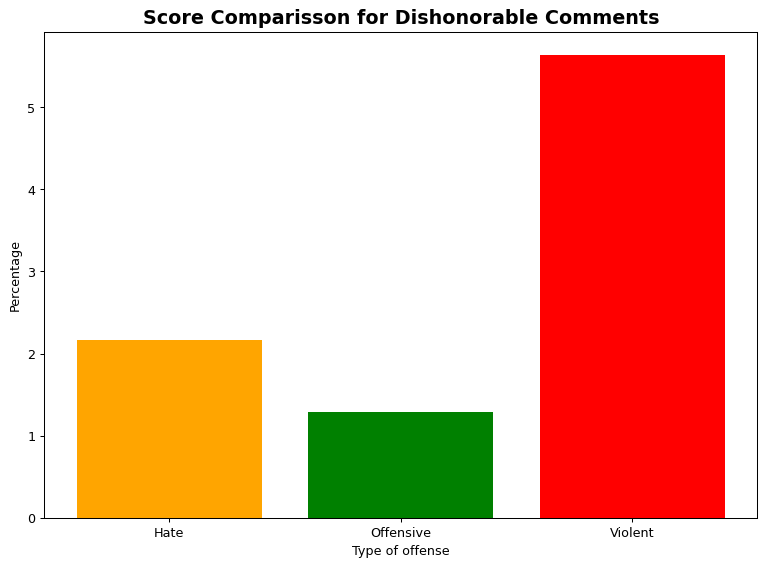

In [160]:
values = [percentage_total_hate, percentage_total_offensive, percentage_total_violent]

plt.figure(figsize=(10,7), dpi= 92)
plt.bar(['Hate', 'Offensive', 'Violent'], values, color=['orange', 'green', 'red'])
plt.title('Score Comparisson for Dishonorable Comments', fontsize=15, fontweight='bold')
plt.xlabel('Type of offense')
plt.ylabel('Percentage')
plt.show()

## Feature Extraction

In [134]:
# Create a new column to convert the title column from list to string

df['str_title'] = df['title'].astype(str)
df.dtypes

Tweet ID                        int64
Date Created                   object
Number of Likes                 int64
Number of Replies               int64
Number of Retweets              int64
Source of Tweet                object
Tweet                          object
cleaned_tweet                  object
title                          object
length                          int64
hate_score                      int64
hate_score_percentage         float64
offensive_score                 int64
offensive_score_percentage    float64
violent_score                   int64
str_title                      object
dtype: object

In [147]:
# For loop to extract features based on positive reviews

feature_extractions = dict()                                # Create a dictionary

for index, row in df.iterrows():                            # Iterate through each row for the positive comments column
    doc = nlp(row["str_title"])
    for token in doc:                                       # Iterate through each word within that row
        if token.text not in ("'", 'iranrevolution', 'iranprotests', 'iranrevoiution', 'freeiran', 'mahsaamini', 'mashaamini', 'iranians'):
            if token.pos_ == 'NOUN':                            # Get the nouns from the sentences
                if token.text in feature_extractions:           # Count the number of times the noun appears
                    feature_extractions[token.text] +=1
                else:
                    feature_extractions[token.text] = 1

# Sort the dictionary where the highest number of features are on the top, then show the top 10 features
feature_extractions_sorted = sorted(feature_extractions.items(), key = lambda x: x[1], reverse = True)
top_five_feature_extractions = feature_extractions_sorted[0:10]
top_five_feature_extractions

[('amini', 1644),
 ('regime', 1386),
 ('freedom', 1094),
 ('people', 1071),
 ('women', 1011),
 ('womanlifefreedom', 553),
 ('forces', 507),
 ('mahsa', 488),
 ('woman', 478),
 ('life', 367)]

In [149]:
# View Full List
feature_extractions_sorted

[('amini', 1644),
 ('regime', 1386),
 ('freedom', 1094),
 ('people', 1071),
 ('women', 1011),
 ('womanlifefreedom', 553),
 ('forces', 507),
 ('mahsa', 488),
 ('woman', 478),
 ('life', 367),
 ('security', 365),
 ('video', 344),
 ('opiran', 310),
 ('protests', 291),
 ('republic', 280),
 ('nikashakarami', 273),
 ('protesters', 270),
 ('time', 266),
 ('potus', 259),
 ('hijabs', 257),
 ('years', 248),
 ('death', 240),
 ('year', 239),
 ('world', 238),
 ('womenlifefreedom', 232),
 ('tehran', 231),
 ('government', 227),
 ('today', 223),
 ('voice', 221),
 ('mullahs', 211),
 ('unicef', 210),
 ('iranrevulotion', 207),
 ('revolution', 207),
 ('news', 199),
 ('zanzendegiazadi', 190),
 ('days', 183),
 ('support', 183),
 ('nikashakrami', 181),
 ('human', 178),
 ('rights', 178),
 ('nika', 169),
 ('students', 167),
 ('country', 167),
 ('pakai', 166),
 ('history', 164),
 ('baru', 162),
 ('mahsazhinaamini', 161),
 ('chitgar', 159),
 ('media', 157),
 ('police', 156),
 ('nazaninboniadi', 149),
 ('mother', 

## Clustering

In [155]:
# Performing clustering to find the number of natural clusters in the data

# Perform a natural clustering on the comments
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# create a list of all the comments
all_comments = list()
for comment in df['title']:
    all_comments.append(' '.join(comment))

# create a tfidf vectorizer object
vectorizer = TfidfVectorizer(stop_words='english')

# fit the vectorizer to the comments
X = vectorizer.fit_transform(all_comments)

# create a kmeans object
kmeans = KMeans(n_clusters=5, random_state=0)

# fit the kmeans object to the vectorizer
kmeans.fit(X)

# get the cluster labels
labels = kmeans.labels_

# add the cluster labels to the dataframe
df['cluster'] = labels
df.head(10)

,Tweet ID,Date Created,Number of Likes,Number of Replies,Number of Retweets,Source of Tweet,Tweet,cleaned_tweet,title,length,hate_score,hate_score_percentage,offensive_score,offensive_score_percentage,violent_score,str_title,cluster
0,1585078850253647872,2022-10-26 01:20:21+00:00,0,0,0,Twitter for Android,#MahsaAmini\n#HosainRonaghi\n#Evin\n#OpIran\n#...,mahsaamini hosainronaghi evin opiran مهسا امین...,"[mahsaamini, hosainronaghi, evin, opiran, jvlys]",5,0,0.000000,0,0.000000,0,"['mahsaamini', 'hosainronaghi', 'evin', 'opira...",2
1,1585078759543099392,2022-10-26 01:20:00+00:00,0,0,1,Twitter Web App,"#IranRevolution2022—October 25, Day 40\nTehran...",day tehran iran tabatabaei university student ...,"[october, tehran, iran, capital, allameh, taba...",18,4,22.222222,2,11.111111,3,"['october', 'tehran', 'iran', 'capital', 'alla...",2
2,1585078685815611393,2022-10-26 01:19:42+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...,[mashaamini],1,0,0.000000,0,0.000000,0,['mashaamini'],2
3,1585078413328408576,2022-10-26 01:18:37+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...,"[mashaamini, semblerait, forces, oppressives, ...",7,0,0.000000,1,14.285714,2,"['mashaamini', 'semblerait', 'forces', 'oppres...",2
4,1585077627765002240,2022-10-26 01:15:30+00:00,1,0,0,Twitter Web App,Abolfazl Adineh Zadeh was killed by the brutal...,abolfazl adineh zadeh killed brutal islamic re...,"[abolfazl, adineh, zadeh, brutal, islamic, reg...",12,0,0.000000,0,0.000000,2,"['abolfazl', 'adineh', 'zadeh', 'brutal', 'isl...",3
5,1585077057184477184,2022-10-26 01:13:14+00:00,0,0,0,Twitter for iPhone,"As we get ready for #Election2022, the only th...",get ready thing care want electorate core beli...,"[ready, election, only, thing, electorate, cor...",15,0,0.000000,0,0.000000,3,"['ready', 'election', 'only', 'thing', 'electo...",2
6,1585076848400437248,2022-10-26 01:12:24+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...,"[mashaamini, mise, jour, vummo]",4,0,0.000000,0,0.000000,0,"['mashaamini', 'mise', 'jour', 'vummo']",2
7,1585076359545884673,2022-10-26 01:10:28+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...,"[mashaamini, lourde, sence, insultante, forces...",9,0,0.000000,0,0.000000,2,"['mashaamini', 'lourde', 'sence', 'insultante'...",2
8,1585075918715772929,2022-10-26 01:08:42+00:00,0,0,0,Twitter for iPhone,Forthy days after #MahsaAmini being brutally m...,forthy day mahsaamini brutally murdered rememb...,"[forthy, days, mahsaamini, rest, people, past,...",9,1,11.111111,0,0.000000,2,"['forthy', 'days', 'mahsaamini', 'rest', 'peop...",3
9,1585075178941612032,2022-10-26 01:05:46+00:00,0,0,0,Twitter Web App,#BetheVoiceofIran\n#OpIran \n#Iranprotests2022...,bethevoiceofiran opiran ژینا mahsa amini iran ...,"[bethevoiceofiran, opiran, mahsa, amini, iran]",5,0,0.000000,1,20.000000,0,"['bethevoiceofiran', 'opiran', 'mahsa', 'amini...",3


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


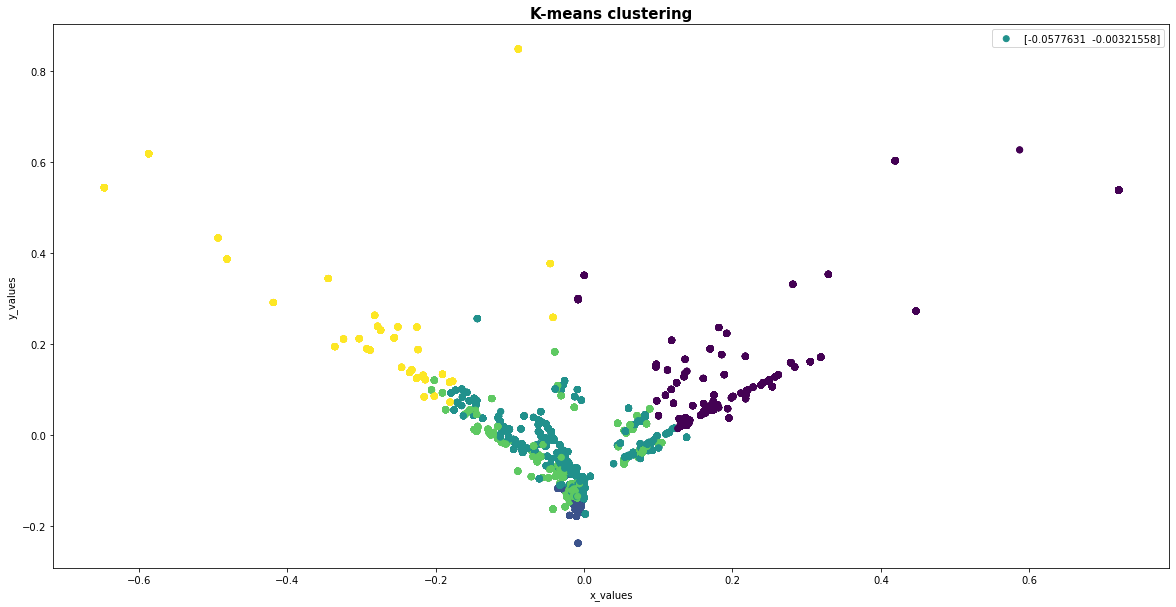

In [173]:
# Plot the clusters
from sklearn.decomposition import PCA

# create a pca object
pca = PCA(n_components=2)

# fit the pca object to the vectorizer
pca.fit(X.toarray())

# get the first two principal components
data2D = pca.transform(X.toarray())

# plot the clusters
plt.figure(figsize=(20,10))
plt.scatter(data2D[:,0], data2D[:,1], c=labels)
# Add legend, title and axis names
plt.legend(data2D)
plt.title('K-means clustering', fontsize=15, fontweight='bold')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.show()

In [157]:
# Check the top 10 words in each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(5):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print('\n')

Cluster 0:
 iranrevoiution
 mahsaamini
 iranintlbrk
 pouriazeraati
 sima
 sabet
 opiran
 samrasoulpour
 amini
 mahsa


Cluster 1:
 hijab
 women
 muslim
 strars
 islam
 allah
 news
 anderson
 fernandes
 proposal


Cluster 2:
 mahsaamini
 mashaamini
 opiran
 amini
 freeiran
 mahsa
 iranian
 iranrevoiution
 mahsazhinaamini
 regime


Cluster 3:
 iran
 mahsaamini
 freedom
 regime
 mahsa
 amini
 freeiran
 people
 opiran
 iranrevoiution


Cluster 4:
 freeiran
 mahsaamini
 opiran
 mahsa
 oplran
 mahsaaamini
 iranrevoiution
 nikashakarami
 amini
 iran




In [159]:
# Get 5 random comments from each cluster
for i in range(5):
    print("Cluster %d:" % i)
    for comment in df[df['cluster'] == i]['title'].sample(5):
        print(' '.join(comment))
    print('\n')

Cluster 0:
those that history winston churchill iranrevoiution iranianrevolution
iranrevoiution ovvtcwnb
sima sabet iranrevoiution
hassanronaghi iranrevoiution
cicikhanoom iranrevoiution


Cluster 1:
minat bisa langsung khalisa dress arafa hijab dress exlusive dibuat dengan material shakilla premium bahannya adem jatuh nerawang gampang kusut detail dress ruffle timbul busui hkgptkjp
hijab strars
yang kabel karna pake hijab klau wireless galiat gitu wkwkwk terus gweh ngobrol
tythefisch real women iran hijab people nobody interested malala story today decade
omid people masaamini iranians didn masks their face outdoors problem mask hijab same thing virtue fear government control


Cluster 2:
revolution party buries itself citizens regime desperation this beginning freeiran mahsa amini jzaqhy

mashaamini semblerait forces oppressives massent saqqez jgwe
children potus commission downingstreet anything phone jakesullivan statedeptspox unhumanrights unicef women firemalley mahsaaminin buwsc

## Clustering on Hate Score

In [197]:
df.columns

Index(['Tweet ID', 'Date Created', 'Number of Likes', 'Number of Replies',
       'Number of Retweets', 'Source of Tweet', 'Tweet', 'cleaned_tweet',
       'title', 'length', 'hate_score', 'hate_score_percentage',
       'offensive_score', 'offensive_score_percentage', 'violent_score',
       'str_title', 'cluster', 'violent_score_percentage'],
      dtype='object')

In [200]:
df2 = df.dropna()

len(df), len(df2)

(17818, 17405)

In [201]:
y_predicted = kmeans.fit_predict(df2[['hate_score_percentage', 'offensive_score_percentage', 'violent_score_percentage', 'length']])

In [203]:
df2['predicted_cluster'] = y_predicted
df.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Tweet ID,Date Created,Number of Likes,Number of Replies,Number of Retweets,Source of Tweet,Tweet,cleaned_tweet,title,length,hate_score,hate_score_percentage,offensive_score,offensive_score_percentage,violent_score,str_title,cluster,violent_score_percentage
0,1585078850253647872,2022-10-26 01:20:21+00:00,0,0,0,Twitter for Android,#MahsaAmini\n#HosainRonaghi\n#Evin\n#OpIran\n#...,mahsaamini hosainronaghi evin opiran مهسا امین...,"[mahsaamini, hosainronaghi, evin, opiran, jvlys]",5,0,0.000000,0,0.000000,0,"['mahsaamini', 'hosainronaghi', 'evin', 'opira...",2,0.000000
1,1585078759543099392,2022-10-26 01:20:00+00:00,0,0,1,Twitter Web App,"#IranRevolution2022—October 25, Day 40\nTehran...",day tehran iran tabatabaei university student ...,"[october, tehran, iran, capital, allameh, taba...",18,4,22.222222,2,11.111111,3,"['october', 'tehran', 'iran', 'capital', 'alla...",2,16.666667
2,1585078685815611393,2022-10-26 01:19:42+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...,[mashaamini],1,0,0.000000,0,0.000000,0,['mashaamini'],2,0.000000
3,1585078413328408576,2022-10-26 01:18:37+00:00,0,0,0,Twitter Web App,#IranRevolution #IranProtests #MashaAmini #اع...,iranrevolution iranprotests mashaamini اعتراضا...,"[mashaamini, semblerait, forces, oppressives, ...",7,0,0.000000,1,14.285714,2,"['mashaamini', 'semblerait', 'forces', 'oppres...",2,28.571429
4,1585077627765002240,2022-10-26 01:15:30+00:00,1,0,0,Twitter Web App,Abolfazl Adineh Zadeh was killed by the brutal...,abolfazl adineh zadeh killed brutal islamic re...,"[abolfazl, adineh, zadeh, brutal, islamic, reg...",12,0,0.000000,0,0.000000,2,"['abolfazl', 'adineh', 'zadeh', 'brutal', 'isl...",3,16.666667


In [210]:
df2.columns

Index(['Tweet ID', 'Date Created', 'Number of Likes', 'Number of Replies',
       'Number of Retweets', 'Source of Tweet', 'Tweet', 'cleaned_tweet',
       'title', 'length', 'hate_score', 'hate_score_percentage',
       'offensive_score', 'offensive_score_percentage', 'violent_score',
       'str_title', 'cluster', 'violent_score_percentage',
       'predicted_cluster'],
      dtype='object')

In [211]:
df2[['hate_score_percentage', 'offensive_score_percentage', 'violent_score_percentage', 'length', 'predicted_cluster']]

,hate_score_percentage,offensive_score_percentage,violent_score_percentage,length,predicted_cluster
0,0.000000,0.000000,0.000000,5,1
1,22.222222,11.111111,16.666667,18,3
2,0.000000,0.000000,0.000000,1,1
3,0.000000,14.285714,28.571429,7,3
4,0.000000,0.000000,16.666667,12,3
...,...,...,...,...,...
17812,0.000000,0.000000,0.000000,6,1
17813,0.000000,0.000000,0.000000,1,1
17814,0.000000,0.000000,0.000000,10,1
17815,0.000000,0.000000,0.000000,13,2


In [212]:
np.unique(df2['predicted_cluster'])

array([0, 1, 2, 3, 4])

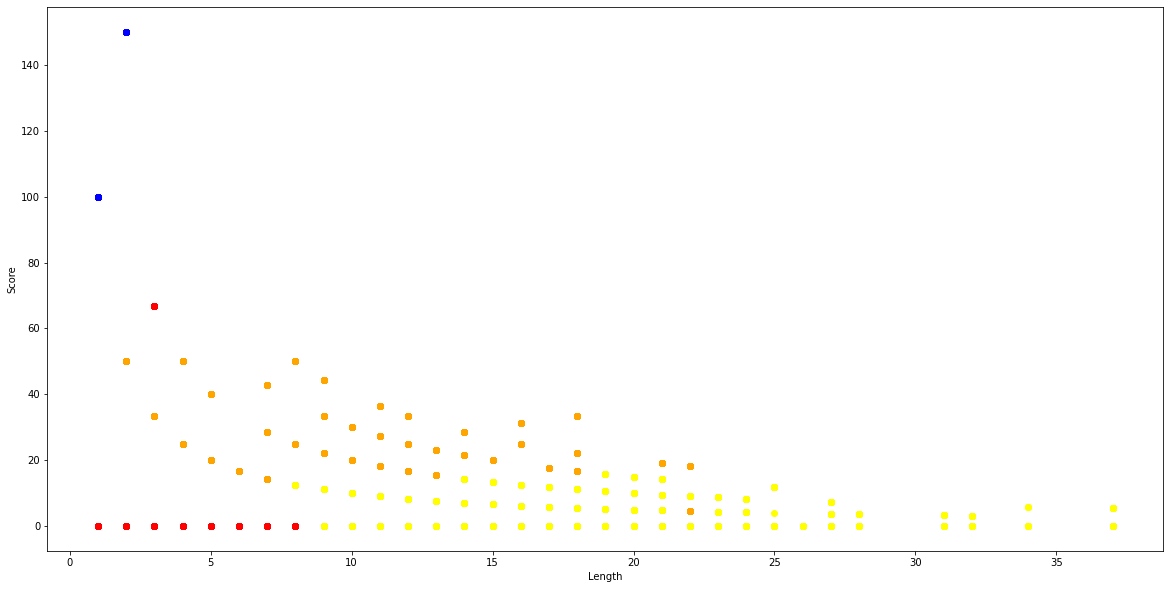

In [220]:
cl1 = df2[df2['predicted_cluster'] == 0]
cl2 = df2[df2['predicted_cluster'] == 1]
cl3 = df2[df2['predicted_cluster'] == 2]
cl4 = df2[df2['predicted_cluster'] == 3]
cl5 = df2[df2['predicted_cluster'] == 4]

plt.figure(figsize=(20,10))

plt.scatter(cl1['length'], cl1['hate_score_percentage'], color = 'green')
plt.scatter(cl2['length'], cl2['hate_score_percentage'], color = 'red')
plt.scatter(cl3['length'], cl3['hate_score_percentage'], color = 'yellow')
plt.scatter(cl4['length'], cl4['hate_score_percentage'], color = 'orange')
plt.scatter(cl5['length'], cl5['hate_score_percentage'], color = 'blue')

plt.scatter(cl1['length'], cl1['offensive_score_percentage'], color = 'green')
plt.scatter(cl2['length'], cl2['offensive_score_percentage'], color = 'red')
plt.scatter(cl3['length'], cl3['offensive_score_percentage'], color = 'yellow')
plt.scatter(cl4['length'], cl4['offensive_score_percentage'], color = 'orange')
plt.scatter(cl5['length'], cl5['offensive_score_percentage'], color = 'blue')

plt.scatter(cl1['length'], cl1['violent_score_percentage'], color = 'green')
plt.scatter(cl2['length'], cl2['violent_score_percentage'], color = 'red')
plt.scatter(cl3['length'], cl3['violent_score_percentage'], color = 'yellow')
plt.scatter(cl4['length'], cl4['violent_score_percentage'], color = 'orange')
plt.scatter(cl5['length'], cl5['violent_score_percentage'], color = 'blue')

plt.xlabel('Length')
plt.ylabel('Score')
plt.show()